importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
import time

converting from excel to dataframe

In [2]:
dict_df = pd.read_excel(r'45A_parameters (3).xlsx',sheet_name = ['.05q','.1q','.2q','.3q'])
q05_df = dict_df.get('.05q') #contains 0.05q data
q1_df = dict_df.get('.1q') #contains 0.1q data
q2_df = dict_df.get('.2q') #contains 0.2q data
q3_df = dict_df.get('.3q') #contains 0.3q data

# .05

data preprocessing

In [43]:
q05_df=q05_df.rename(columns={'soc.1':'SOC'})
q05_df=q05_df.rename(columns={'power  loss':'P loss'})
q05_df['p_pump']=0.139751
q05_df['total_power'] = q05_df['P loss']+q05_df['p_pump']

q05_df.head()

,time,Unnamed: 1,soc,v terminal,p charging,p pump,Unnamed: 6,time.1,SOC,R0,R1,C,Rint,P loss,p_pump,total_power
0,38600.0,0.0,0.001000,28.323122,1274.680227,0.139751,NaN,0,0.000000,0.285073,0.007542,0.000000,0.285073,576.247354,0.139751,576.387105
1,38700.0,100.0,0.096158,30.550040,1374.891536,0.139751,NaN,1,0.000057,0.285039,0.007542,38655.379555,0.285082,576.264424,0.139751,576.404175
2,38800.0,200.0,0.101340,30.578146,1376.156315,0.139751,NaN,2,0.000114,0.285004,0.007542,54794.304980,0.285090,576.281490,0.139751,576.421241
3,38900.0,300.0,0.106522,30.605022,1377.365746,0.139751,NaN,3,0.000171,0.284970,0.007542,64149.908819,0.285098,576.298553,0.139751,576.438304
4,39000.0,400.0,0.111704,30.630787,1378.525165,0.139751,NaN,4,0.000229,0.284936,0.007542,70762.311620,0.285107,576.315613,0.139751,576.455364


separating into X and Y

In [44]:
input = ['SOC']

X05 = q05_df[input]
Y05 = q05_df['total_power']

In [65]:
#splitting into test and train data

# change X1, Y1 here accordingly for 0.05q,0.1q... values
X_train, X_test, Y_train, Y_test = train_test_split(X05,Y05,test_size=0.2,random_state=8)
initial_xgbr = xgb(n_estimators=50, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
print(initial_xgbr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
(3501,)


making the model

In [46]:
# finding out best hyper parameters
n=50
lr=0.06
my_str = "Model for no of estimators ="
my_str2 = "and learning rate ="
for i in range(5):
  my_int = n
  lr=0.06
  for j in range (5):
    my_int2=round(lr,2)

    initial_xgbr = xgb(n_estimators=n, max_depth=3, learning_rate=lr, objective='reg:squarederror')
    initial_xgbr.fit(X_train, Y_train)
    y_pred = initial_xgbr.predict(X_test)

    result = f'{my_str} {my_int} {my_str2} {my_int2}'
    print(result)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    mae = mean_absolute_error(Y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r_squared = r2_score(Y_test, y_pred)
    print("R-squared (R²) value:", r_squared)
    print("\n")
    lr+=0.01

  n+=25


# as no of estimators increases, the MSE and MAE decreases and R2 increases.

In [48]:
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=8)
cv_results = cross_val_score(initial_xgbr, X05, Y05, cv=kf, scoring='neg_mean_squared_error')
print("Initial Cross-validation results:")
print("Mean Squared Error: {:.2f} (+/- {:.2f})".format(-cv_results.mean(), cv_results.std()))

Initial Cross-validation results:
Mean Squared Error: 5.97 (+/- 1.48)


In [49]:
def best_param():
  param_grid = {
      'n_estimators': [50, 75, 100, 125, 150],
      'max_depth': [3],
      'learning_rate': [0.06, 0.07, 0.08, 0.09, 0.1]
  }

  grid_search = GridSearchCV(initial_xgbr, param_grid, cv=k_folds, scoring='neg_mean_squared_error')
  grid_search.fit(X_train, Y_train)
  #
  # Get the best hyperparameters from the grid search
  best_params = grid_search.best_params_

  print("Best Hyperparameters:")
  print(best_params)

In [50]:
final_model = xgb(best_param())

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [51]:
def time_taken():
  start_train = time.time()
  # Fit the model on the entire training set
  final_model.fit(X_train, Y_train)
  end_train = time.time()

  start_test = time.time()
  # Make predictions on the test set
  y_pred = final_model.predict(X_test)
  end_test = time.time()

  # making predictions on the training set
  y_pred_train = final_model.predict(X_train)

  test_mse = mean_squared_error(Y_test, y_pred)
  print("Test Root Mean Squared Error: {:.2f}".format(np.sqrt(test_mse)))

  train_mse =mean_squared_error(Y_train, y_pred_train)
  print("Train Root Mean Squared Error : {:.2f}".format(np.sqrt(train_mse)))

  print(f"Training Time : {(end_train-start_train):.3f}")
  print(f"Prediction Time : {(end_test-start_test):.3f}")


In [52]:
time_taken()

Test Root Mean Squared Error: 2.99
Train Root Mean Squared Error : 2.39
Training Time : 0.086
Prediction Time : 0.012


plots

In [95]:
def create_plot():
  # Create a scatter plot
  plt.figure(figsize=(6,6))
  sns.scatterplot(x=Y_test, y=y_pred, color='blue', alpha=0.7,label='Predicted Values')

  # Add a diagonal line for reference (perfect predictions)
  plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', linewidth=2,label= 'Actual Values')

  # Set plot labels and title
  plt.xlabel('Actual values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')

  # Show the plot
  plt.show()


(3501,)
(3501,)


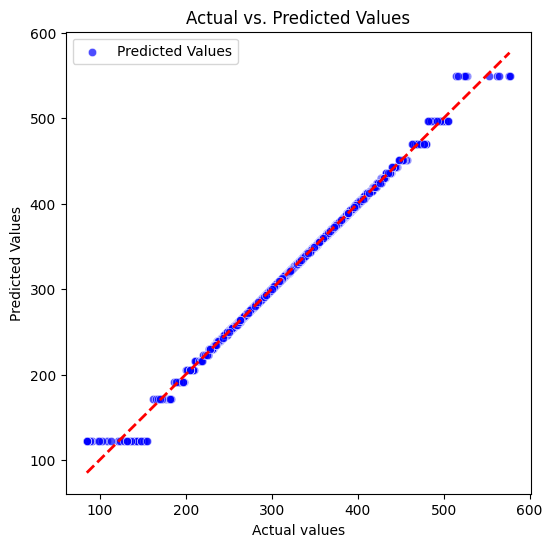

In [54]:
create_plot()

# 0.1

In [68]:
q1_df['p_pump']=0.90962175
q1_df['total_power'] = q1_df['P loss']+q1_df['p_pump']
q1_df.head()

,time,Unnamed: 1,soc,vterminal,pcharging,p pump,Unnamed: 6,time.1,SOC,R0,R1,C,Rint,P loss,p_pump,total_power
0,38600.0,0.0,0.001000,28.323122,1275.450098,0.909622,NaN,0,0.000000,0.279789,0.00233,0.000000,0.279789,565.565757,0.909622,566.475379
1,38700.0,100.0,0.049518,30.206790,1360.215168,0.909622,NaN,1,0.000054,0.279785,0.00233,44838.047141,0.279798,565.584176,0.909622,566.493798
2,38800.0,200.0,0.054701,30.257139,1362.480879,0.909622,NaN,2,0.000109,0.279782,0.00233,89433.070233,0.279807,565.602591,0.909622,566.512213
3,38900.0,300.0,0.059883,30.303214,1364.554245,0.909622,NaN,3,0.000163,0.279779,0.00233,121280.931072,0.279816,565.621003,0.909622,566.530625
4,39000.0,400.0,0.065065,30.345727,1366.467348,0.909622,NaN,4,0.000217,0.279775,0.00233,143793.729333,0.279825,565.639411,0.909622,566.549033


separating into X and y

In [69]:
input = ['SOC']

X1 = q1_df[input]
Y1 = q1_df['total_power']

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X1,Y1,test_size=0.2,random_state=8)
xgb_1 = xgb(n_estimators=50, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
print(xgb_1)
print(Y_test.shape)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
(3681,)


In [71]:
# finding out best hyper parameters
n=50
lr=0.06
my_str = "Model for no of estimators ="
my_str2 = "and learning rate ="
for i in range(5):
  my_int = n
  lr=0.06
  for j in range (5):
    my_int2=round(lr,2)

    initial_xgbr = xgb(n_estimators=n, max_depth=3, learning_rate=lr, objective='reg:squarederror')
    initial_xgbr.fit(X_train, Y_train)
    y_pred = initial_xgbr.predict(X_test)

    result = f'{my_str} {my_int} {my_str2} {my_int2}'
    print(result)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    mae = mean_absolute_error(Y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r_squared = r2_score(Y_test, y_pred)
    print("R-squared (R²) value:", r_squared)
    print("\n")
    lr+=0.01

n+=25


# as no of estimators increases, the MSE and MAE decreases and R2 increases.

Model for no of estimators = 50 and learning rate = 0.06
Root Mean Squared Error: 4.221611008120984
Mean Absolute Error: 2.068639928955523
R-squared (R²) value: 0.9930115627876122


Model for no of estimators = 50 and learning rate = 0.07
Root Mean Squared Error: 3.467262435139102
Mean Absolute Error: 1.3882206946266928
R-squared (R²) value: 0.9952859186892874


Model for no of estimators = 50 and learning rate = 0.08
Root Mean Squared Error: 3.1179961919601245
Mean Absolute Error: 1.0163497741138254
R-squared (R²) value: 0.9961878076874086


Model for no of estimators = 50 and learning rate = 0.09
Root Mean Squared Error: 2.973305320924614
Mean Absolute Error: 0.8851321858274381
R-squared (R²) value: 0.9965334085904447


Model for no of estimators = 50 and learning rate = 0.1
Root Mean Squared Error: 2.9088936388056443
Mean Absolute Error: 0.8606644251879998
R-squared (R²) value: 0.9966819775189983


Model for no of estimators = 50 and learning rate = 0.06
Root Mean Squared Error: 4.2

In [72]:
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=8)
cv_results = cross_val_score(initial_xgbr, X1, Y1, cv=kf, scoring='neg_mean_squared_error')
print("Initial Cross-validation results:")
print("Mean Squared Error: {:.2f} (+/- {:.2f})".format(-cv_results.mean(), cv_results.std()))

Initial Cross-validation results:
Mean Squared Error: 6.02 (+/- 1.34)


In [73]:
best_param()

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


In [74]:
final_model = xgb(best_param())

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [75]:
time_taken()

Test Root Mean Squared Error: 2.79
Train Root Mean Squared Error : 2.32
Training Time : 0.100
Prediction Time : 0.013


(3681,)
(3681,)


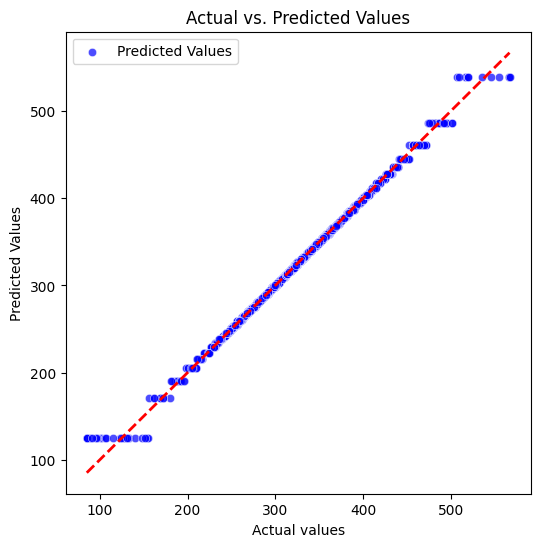

In [76]:
create_plot()

# 0.2

In [77]:
q2_df['p_pump']=6.2620128
q2_df['total_power'] = q2_df['Power loss']+q2_df['p_pump']
q2_df.head()

,time,Unnamed: 1,soc,v terminal,p charging,p pump,Unnamed: 6,time.1,SOC,R0,R1,C,R int,Power loss,p_pump,total_power
0,38600.0,0.0,0.001000,28.323122,1280.802489,6.262013,NaN,0,0.000000,0.275472,0.000222,0.000000,0.275472,556.839920,6.262013,563.101933
1,38700.0,100.0,0.026199,29.890607,1351.339331,6.262013,NaN,1,0.000053,0.275481,0.000222,44841.267721,0.275482,556.860404,6.262013,563.122417
2,38800.0,200.0,0.031381,29.979404,1355.335173,6.262013,NaN,2,0.000106,0.275490,0.000222,89445.906611,0.275492,556.880883,6.262013,563.142896
3,38900.0,300.0,0.036563,30.055062,1358.739799,6.262013,NaN,3,0.000159,0.275499,0.000222,133815.165369,0.275503,556.901359,6.262013,563.163372
4,39000.0,400.0,0.041745,30.121082,1361.710680,6.262013,NaN,4,0.000212,0.275508,0.000222,177950.286103,0.275513,556.921831,6.262013,563.183844


In [78]:
input = ['SOC']

X2 = q2_df[input]
Y2 = q2_df['total_power']

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X2,Y2,test_size=0.2,random_state=8)
xgb_1 = xgb(n_estimators=50, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
print(xgb_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [80]:
# finding out best hyper parameters
n=50
lr=0.06
my_str = "Model for no of estimators ="
my_str2 = "and learning rate ="
for i in range(5):
  my_int = n
  lr=0.06
  for j in range (5):
    my_int2=round(lr,2)

    xgb_1 = xgb(n_estimators=n, max_depth=3, learning_rate=lr, objective='reg:squarederror')
    xgb_1.fit(X_train, Y_train)
    y_pred = xgb_1.predict(X_test)

    result = f'{my_str} {my_int} {my_str2} {my_int2}'
    print(result)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    mae = mean_absolute_error(Y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r_squared = r2_score(Y_test, y_pred)
    print("R-squared (R²) value:", r_squared)
    print("\n")
    lr+=0.01

  n+=25


# as no of estimators increases, the MSE and MAE decreases and R2 increases.

Model for no of estimators = 50 and learning rate = 0.06
Root Mean Squared Error: 3.73745285786391
Mean Absolute Error: 1.943705322033543
R-squared (R²) value: 0.9939347240693348


Model for no of estimators = 50 and learning rate = 0.07
Root Mean Squared Error: 3.0403377545420764
Mean Absolute Error: 1.2935411578579927
R-squared (R²) value: 0.9959863196571022


Model for no of estimators = 50 and learning rate = 0.08
Root Mean Squared Error: 2.713605170507298
Mean Absolute Error: 0.9524858137338029
R-squared (R²) value: 0.9968026334103789


Model for no of estimators = 50 and learning rate = 0.09
Root Mean Squared Error: 2.5879761543729747
Mean Absolute Error: 0.8324689922319392
R-squared (R²) value: 0.9970918308893498


Model for no of estimators = 50 and learning rate = 0.1
Root Mean Squared Error: 2.5420253493506375
Mean Absolute Error: 0.8068209511802579
R-squared (R²) value: 0.997194186047367


Model for no of estimators = 75 and learning rate = 0.06
Root Mean Squared Error: 2.57

In [81]:
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=8)
cv_results = cross_val_score(xgb_1, X2, Y2, cv=kf, scoring='neg_mean_squared_error')
print("Initial Cross-validation results:")
print("Mean Squared Error: {:.2f} (+/- {:.2f})".format(-cv_results.mean(), cv_results.std()))

Initial Cross-validation results:
Mean Squared Error: 5.27 (+/- 0.52)


In [82]:
best_param()

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


In [83]:
final_model = xgb(best_param())

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [84]:
time_taken()

Test Root Mean Squared Error: 2.44
Train Root Mean Squared Error : 2.29
Training Time : 0.096
Prediction Time : 0.009


(3781,)
(3781,)


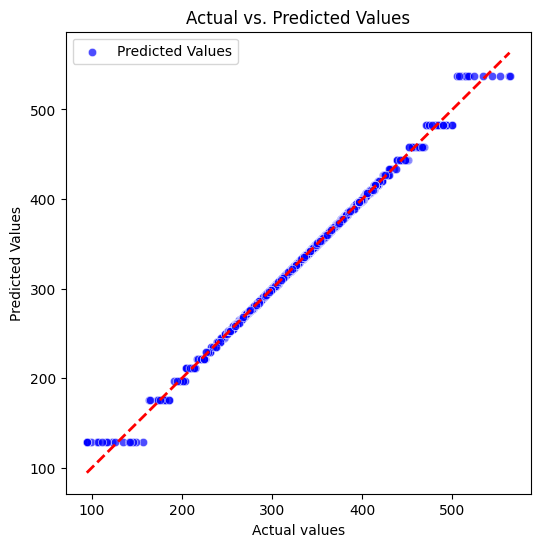

In [85]:
create_plot()

# 0.3

In [86]:
q3_df['p_pump']=19.726427
q3_df['total_power'] = q3_df['power loss']+q3_df['p_pump']
q3_df.head()

,time,Unnamed: 1,soc,v terminal,p charging,p pump,Unnamed: 6,time.1,SOC,R0,R1,C,Rint,power loss,p_pump,total_power
0,38600.0,0.0,0.001000,28.323122,1294.266903,19.726427,NaN,0,0.000000,0.273997,0.000021,0.000000,0.273997,553.857274,19.726427,573.583701
1,38700.0,100.0,0.018425,29.718793,1357.072116,19.726427,NaN,1,0.000053,0.274007,0.000021,44841.891532,0.274007,553.878069,19.726427,573.604496
2,38800.0,200.0,0.023608,29.839604,1362.508610,19.726427,NaN,2,0.000105,0.274017,0.000021,89448.393099,0.274017,553.898860,19.726427,573.625287
3,38900.0,300.0,0.028790,29.936938,1366.888632,19.726427,NaN,3,0.000158,0.274027,0.000021,133820.740342,0.274028,553.919648,19.726427,573.646075
4,39000.0,400.0,0.033972,30.018619,1370.564264,19.726427,NaN,4,0.000211,0.274037,0.000021,177960.162413,0.274038,553.940432,19.726427,573.666859


In [87]:
input = ['SOC']

X3 = q3_df[input]
Y3 = q3_df['total_power']

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X3,Y3,test_size=0.2,random_state=8)
xgb_1 = xgb(n_estimators=50, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
print(xgb_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [89]:
# finding out best hyper parameters
n=50
lr=0.06
my_str = "Model for no of estimators ="
my_str2 = "and learning rate ="
for i in range(5):
  my_int = n
  lr=0.06
  for j in range (5):
    my_int2=round(lr,2)

    xgb_1 = xgb(n_estimators=n, max_depth=3, learning_rate=lr, objective='reg:squarederror')
    xgb_1.fit(X_train, Y_train)
    y_pred = xgb_1.predict(X_test)

    result = f'{my_str} {my_int} {my_str2} {my_int2}'
    print(result)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    mae = mean_absolute_error(Y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r_squared = r2_score(Y_test, y_pred)
    print("R-squared (R²) value:", r_squared)
    print("\n")
    lr+=0.01

  n+=25


# as no of estimators increases, the MSE and MAE decreases and R2 increases.

Model for no of estimators = 50 and learning rate = 0.06
Root Mean Squared Error: 3.9543147585977323
Mean Absolute Error: 1.97192940877855
R-squared (R²) value: 0.9932989371078019


Model for no of estimators = 50 and learning rate = 0.07
Root Mean Squared Error: 3.2465471880424546
Mean Absolute Error: 1.318541117559038
R-squared (R²) value: 0.9954830564611736


Model for no of estimators = 50 and learning rate = 0.08
Root Mean Squared Error: 2.9338083396747487
Mean Absolute Error: 0.9871341410124809
R-squared (R²) value: 0.9963113733454507


Model for no of estimators = 50 and learning rate = 0.09
Root Mean Squared Error: 2.7897357572398156
Mean Absolute Error: 0.8580645013394623
R-squared (R²) value: 0.9966647579267109


Model for no of estimators = 50 and learning rate = 0.1
Root Mean Squared Error: 2.7349585591552183
Mean Absolute Error: 0.8346396898358367
R-squared (R²) value: 0.9967944487627288


Model for no of estimators = 75 and learning rate = 0.06
Root Mean Squared Error: 2.

In [90]:
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=8)
cv_results = cross_val_score(initial_xgbr, X3, Y3, cv=kf, scoring='neg_mean_squared_error')
print("Initial Cross-validation results:")
print("Mean Squared Error: {:.2f} (+/- {:.2f})".format(-cv_results.mean(), cv_results.std()))

Initial Cross-validation results:
Mean Squared Error: 5.87 (+/- 1.27)


In [91]:
best_param()

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


In [92]:
final_model = xgb(best_param())

Best Hyperparameters:
{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [93]:
time_taken()

Test Root Mean Squared Error: 2.63
Train Root Mean Squared Error : 2.28
Training Time : 0.095
Prediction Time : 0.012


(3801,)
(3801,)


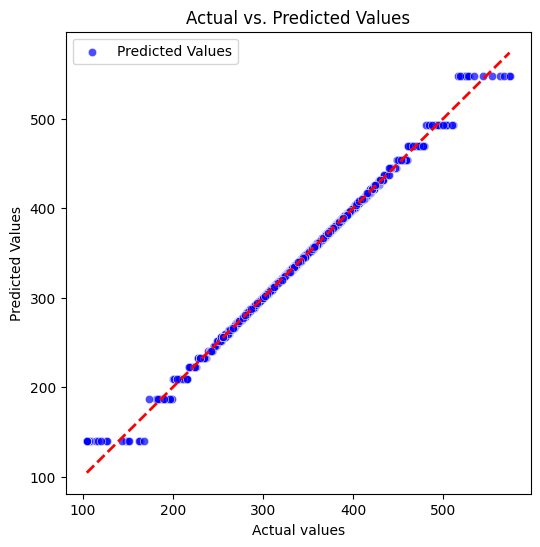

In [94]:
create_plot()